In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import networkx as nx
import numpy as np
import sklearn

books = pd.read_csv('books.csv')
ratings = pd.read_csv('ratings.csv')
#toread = pd.read_csv('to_read.csv')
#tags = pd.read_csv('tags.csv')
#book_tags = pd.read_csv('book_tags.csv')

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.linalg import triu

from scipy.sparse import hstack
from gensim.models import Word2Vec
import gensim
from scipy.sparse import csr_matrix


# Data preprocessing
ratings = ratings.drop_duplicates(subset=['user_id', 'book_id'])
ratings = ratings[ratings['user_id'].isin(ratings['user_id'].value_counts()[ratings['user_id'].value_counts() >= 3].index)]


books.drop_duplicates(subset='title', inplace=True)
books.dropna(subset=['original_title'], inplace=True)
books = books[~books['book_id'].isin(books[books.isnull().any(axis=1)]['book_id'])]

# Remove any ratings that do not have a corresponding book in the books DataFrame
ratings = ratings[ratings['book_id'].isin(books['book_id'])]

# Function to split each group and ensure both training and testing sets include each user
def split_ratings(group, frac=0.2):
    test_indices = group.sample(frac=frac, random_state=42).index
    train_indices = group.index.difference(test_indices)
    return train_indices, test_indices

# Apply the split function to each user group
split_indices = ratings.groupby('user_id').apply(lambda x: split_ratings(x))

# Separate indices for train and test sets
train_indices = split_indices.map(lambda x: x[0]).explode().dropna()
test_indices = split_indices.map(lambda x: x[1]).explode().dropna()

# Use indices to separate the train and test dataframes
train_set = ratings.loc[train_indices]
test_set = ratings.loc[test_indices]

# Ensure there are no missing books in train that are in test
missing_in_train = set(test_set['book_id']).difference(train_set['book_id'])
if missing_in_train:
    # Get rows for missing book_ids from test_set
    rows_to_move = test_set[test_set['book_id'].isin(missing_in_train)]
    # Append these rows to the train_set
    train_set = pd.concat([train_set, rows_to_move], ignore_index=True)
    # Remove these rows from test_set
    test_set = test_set[~test_set['book_id'].isin(missing_in_train)]

# Output results
print("Training Data:")
print(train_set.head())
print("Total rows in training data:", len(train_set))
print("Num Unique Users in Training Data: ", train_set.user_id.nunique())

print("\nTesting Data:")
print(test_set.head())
print("Total rows in testing data:", len(test_set))
print("Num Unique Users in Testing Data: ", test_set.user_id.nunique())

Training Data:
    user_id  book_id  rating
75        1      268       3
76        1     5556       3
77        1     3638       3
79        1      867       3
80        1       47       3
Total rows in training data: 4244459
Num Unique Users in Training Data:  53424

Testing Data:
        user_id  book_id  rating
999524        1      485       4
230485        1     2063       4
78            1     1796       5
999532        1      496       3
999504        1       54       3
Total rows in testing data: 1061247
Num Unique Users in Testing Data:  53422


In [9]:
import gc 
#del books
#del ratings
gc.collect()

1142

In [10]:
train_set['book_id'].nunique()

7834

### Base Graph

In [11]:
# 6m30 for computing 
import networkx as nx

G = nx.Graph()

# Add nodes for users and books
users = train_set['user_id'].unique()
books = train_set['book_id'].unique()
G.add_nodes_from(users, bipartite=0, type='user')
G.add_nodes_from(books, bipartite=1, type='book')

# Add edges representing user-book interactions (ratings)
edges = [(row['user_id'], row['book_id'], {'rating': row['rating']}) for _, row in train_set.iterrows()]
G.add_edges_from(edges)


# Check the number of nodes and edges in the graph
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


Number of nodes: 53424
Number of edges: 4241118


In [12]:
import gc
del users
del books
del edges

In [13]:
gc.collect()

30

### Reducing graph size

#### Minimum spanning tree

In [14]:
# Compute a minimum spanning tree to sparsify the graph
T = nx.minimum_spanning_tree(G)

print("Original number of edges:", G.number_of_edges())
print("Number of edges after sparsification:", T.number_of_edges())

Original number of edges: 4241118
Number of edges after sparsification: 53423


In [15]:

del G 

gc.collect()

53433

In [16]:
del test_set
del test_indices
del train_indices

In [17]:

gc.collect()



30

#### Sparsification 

In [9]:

def sparsify_graph(G, epsilon=0.01):
    n = len(G.nodes)
    k = int(np.log(n) / (epsilon**2))
    edges = list(G.edges)
    np.random.shuffle(edges)
    sparsified_edges = edges[:k]
    SG = nx.Graph()
    SG.add_edges_from(sparsified_edges)
    return SG

sparsified_graph = sparsify_graph(G)

print("Original number of edges:", G.number_of_edges())
print("Number of edges after sparsification:", sparsified_graph.number_of_edges())

Original number of edges: 4241118
Number of edges after sparsification: 108860


#### Community detection 

In [10]:
import community as community_louvain

partition = community_louvain.best_partition(G)

ModuleNotFoundError: No module named 'community'

#### Graph compression 

In [11]:
import zlib
import pickle

adj_list_str = str(G.adjacency())
compressed_adj_list = zlib.compress(pickle.dumps(adj_list_str))

print("Original size of adjacency list (bytes):", len(adj_list_str.encode('utf-8')))
print("Compressed size of adjacency list (bytes):", len(compressed_adj_list))

Original size of adjacency list (bytes): 48
Compressed size of adjacency list (bytes): 62


#### Dimension Reduction : PCA / t-SNE / SVD

In [13]:
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

A_sparse = nx.adjacency_matrix(G)

# Apply Truncated SVD (similar to PCA for sparse matrices)
svd = TruncatedSVD(n_components=2)
svd_result = svd.fit_transform(A_sparse)

In [15]:
svd_result.shape

(53424, 2)

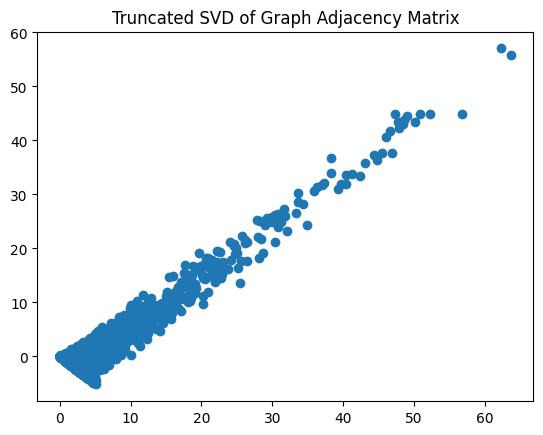

In [16]:
import matplotlib.pyplot as plt
plt.scatter(svd_result[:, 0], svd_result[:, 1])
plt.title('Truncated SVD of Graph Adjacency Matrix')
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 53424 samples in 0.138s...
[t-SNE] Computed neighbors for 53424 samples in 2.920s...
[t-SNE] Computed conditional probabilities for sample 1000 / 53424
[t-SNE] Computed conditional probabilities for sample 2000 / 53424
[t-SNE] Computed conditional probabilities for sample 3000 / 53424
[t-SNE] Computed conditional probabilities for sample 4000 / 53424
[t-SNE] Computed conditional probabilities for sample 5000 / 53424
[t-SNE] Computed conditional probabilities for sample 6000 / 53424
[t-SNE] Computed conditional probabilities for sample 7000 / 53424
[t-SNE] Computed conditional probabilities for sample 8000 / 53424
[t-SNE] Computed conditional probabilities for sample 9000 / 53424
[t-SNE] Computed conditional probabilities for sample 10000 / 53424
[t-SNE] Computed conditional probabilities for sample 11000 / 53424
[t-SNE] Computed conditional probabilities for sample 12000 / 53424
[t-SNE] Computed conditional probabilities for sam

C:\Users\duval\AppData\Local\Temp\ipykernel_17484\1237749347.py:7: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10, cmap='viridis')


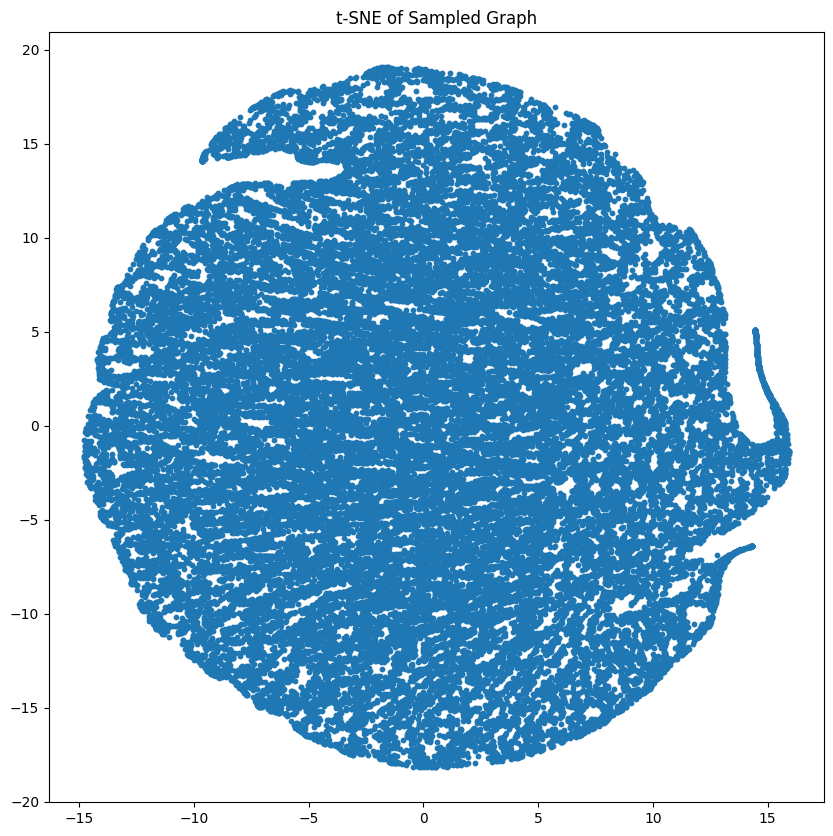

In [19]:
# Step 3: t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300, verbose=2)
tsne_result = tsne.fit_transform(svd_result)

# Visualize the t-SNE result
plt.figure(figsize=(10, 10))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=10, cmap='viridis')
plt.title('t-SNE of Sampled Graph')
plt.show()

In [18]:
from sklearn.decomposition import IncrementalPCA

# Assume G is your large graph
# Create a sparse adjacency matrix
A_sparse = nx.adjacency_matrix(G)

# Apply Incremental PCA
ipca = IncrementalPCA(n_components=2, batch_size=100)
ipca_result = ipca.fit_transform(A_sparse.toarray())

MemoryError: Unable to allocate 10.6 GiB for an array with shape (53424, 53424) and data type int32

In [12]:
from sklearn.manifold import TSNE


# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
tsne_result = tsne.fit_transform(A)

MemoryError: Unable to allocate 21.3 GiB for an array with shape (53424, 53424) and data type float64

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

interaction_matrix = train_set.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

In [6]:
interaction_matrix.shape

(53424, 7834)

In [12]:
from scipy.sparse import csr_matrix

# Convert the interaction matrix to a sparse matrix format
interaction_sparse = csr_matrix(interaction_matrix)

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Define a function to compute cosine similarity in batches
def batch_cosine_similarity(sparse_matrix, batch_size=1000):
    num_users = sparse_matrix.shape[0]
    similarities = []
    
    for start in range(0, num_users, batch_size):
        end = min(start + batch_size, num_users)
        batch_similarity = cosine_similarity(sparse_matrix[start:end], sparse_matrix)
        similarities.append(batch_similarity)
        
    return np.vstack(similarities)

# Compute the cosine similarity in batches
user_similarity = batch_cosine_similarity(interaction_sparse, batch_size=1000)


MemoryError: Unable to allocate 21.3 GiB for an array with shape (53424, 53424) and data type float64

In [ ]:

G_s = nx.Graph()

# Add Nodes
users = train_set['user_id'].unique()
books = train_set['book_id'].unique()

G_s.add_nodes_from(users, bipartite=0)
G_s.add_nodes_from(books, bipartite=1)

# Add Edges
edges = []
for user in users:
    user_books = train_set[train_set['user_id'] == user]
    for book in user_books['book_id']:
        edges.append((user, book, user_books[user_books['book_id'] == book]['rating'].values[0]))

G_s.add_weighted_edges_from(edges)

# Calculate Graph Metrics
degree_distribution = dict(G_s.degree())
clustering_coefficient = nx.clustering(G_s)
pagerank = nx.pagerank(G_s)
connected_components = nx.number_connected_components(G_s)
degree_centrality = nx.degree_centrality(G_s)
closeness_centrality = nx.closeness_centrality(G_s)
betweenness_centrality = nx.betweenness_centrality(G_s)

# Example: Print Degree Distribution
print("Degree Distribution: ", degree_distribution)

# Interpret and Justify Training Choices
# Example: Focusing on high-degree nodes, high PageRank nodes, etc.


#### Compute Metrics 

##### Minimum spanning 

In [19]:
degree_distribution = dict(T.degree())
clustering_coefficient = nx.clustering(T)
pagerank = nx.pagerank(T)
connected_components = nx.number_connected_components(T)
degree_centrality = nx.degree_centrality(T)
closeness_centrality = nx.closeness_centrality(T)
betweenness_centrality = nx.betweenness_centrality(T)

KeyboardInterrupt: 

### kNN to reduce Graph size 

In [21]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Initialize the NearestNeighbors model
nn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_jobs=-1)
nn_model.fit(interaction_sparse)

# Find the k-nearest neighbors for each user
k = 10  # number of nearest neighbors
distances, indices = nn_model.kneighbors(interaction_sparse, n_neighbors=k)

# Convert the neighbors to a similarity matrix
user_similarity_approx = 1 - distances  # cosine distance to similarity

# Create a DataFrame for user similarities
user_ids = interaction_matrix.index
similar_users_list = []

for i, neighbors in enumerate(indices):
    for j, neighbor in enumerate(neighbors):
        if user_ids[i] != user_ids[neighbor]:
            similar_users_list.append((user_ids[i], user_ids[neighbor], user_similarity_approx[i][j]))

similar_users_df = pd.DataFrame(similar_users_list, columns=['user_id_1', 'user_id_2', 'similarity'])

# Sort by similarity and keep the top 100k edges
similar_users_sorted = similar_users_df.sort_values(by='similarity', ascending=False).head(100000)

# Create the Graph
G = nx.Graph()

# Add user nodes
users = train_set['user_id'].unique()
G.add_nodes_from(users, bipartite=0)

# Add book nodes
books = train_set['book_id'].unique()
G.add_nodes_from(books, bipartite=1)

# Add edges (user-book interactions)
edges = train_set.apply(lambda row: (row['user_id'], row['book_id'], row['rating']), axis=1).tolist()
G.add_weighted_edges_from(edges)

# Add edges based on user similarity (thresholded)
user_sim_edges = similar_users_sorted.apply(lambda row: (row['user_id_1'], row['user_id_2'], row['similarity']), axis=1).tolist()
G.add_weighted_edges_from(user_sim_edges)

# Display basic graph info
#print(nx.info(G))

# Calculate Graph Metrics
degree_distribution = dict(G.degree())
clustering_coefficient = nx.clustering(G)
pagerank = nx.pagerank(G)
connected_components = nx.number_connected_components(G)
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print Graph Metrics
print("Degree Distribution: ", degree_distribution)
print("Clustering Coefficient: ", clustering_coefficient)
print("PageRank: ", pagerank)
print("Number of Connected Components: ", connected_components)
print("Degree Centrality: ", degree_centrality)
print("Closeness Centrality: ", closeness_centrality)
print("Betweenness Centrality: ", betweenness_centrality)


AttributeError: module 'networkx' has no attribute 'info'

In [22]:
degree_distribution = dict(G.degree())
clustering_coefficient = nx.clustering(G)
pagerank = nx.pagerank(G)
connected_components = nx.number_connected_components(G)
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Print Graph Metrics
print("Degree Distribution: ", degree_distribution)
print("Clustering Coefficient: ", clustering_coefficient)
print("PageRank: ", pagerank)
print("Number of Connected Components: ", connected_components)
print("Degree Centrality: ", degree_centrality)
print("Closeness Centrality: ", closeness_centrality)
print("Betweenness Centrality: ", betweenness_centrality)